# Text classification and sentiment analysis: Twitter

Once text data has been converted into numerical features using the natural language processing techniques discussed in the previous sections, text classification works just like any other classification task.

In this notebook, we will apply these preprocessing technique to news articles, product reviews, and Twitter data and teach various classifiers to predict discrete news categories, review scores, and sentiment polarity.

## Imports

In [44]:
import warnings
warnings.filterwarnings('ignore')

In [45]:
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# spacy, textblob and nltk for language processing
from textblob import TextBlob

# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score


In [46]:
sns.set_style('white')


## Twitter Sentiment

### Download the data

We use a dataset that contains 1.6 million training and 350 test tweets from 2009 with algorithmically assigned binary positive and negative sentiment scores that are fairly evenly split.

Follow the [instructions](../data/twitter_sentiment.ipynb) to create the dataset.

- 0 - the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive); training data has no neutral tweets
- 1 - the id of the tweet (2087)
- 2 - the date of the tweet (Sat May 16 23:58:44 UTC 2009)
- 3 - the query (lyx). If there is no query, then this value is NO_QUERY. (only test data uses query)
- 4 - the user that tweeted (robotickilldozr)
- 5 - the text of the tweet (Lyx is cool)

### Read and preprocess train/test data

In [47]:
data_path = Path('.', 'data', 'sentiment140')
if not data_path.exists():
    data_path.mkdir(parents=True)

In [48]:
names = ['polarity', 'id', 'date', 'query', 'user', 'text']

Take a few preprocessing steps:
- remove tweets above the legal (at the time) length of 140 characters,
- binarize polarity, and 
- move the data to the faster parquet format.

In [49]:
def load_train_data():
    parquet_file = data_path / 'train3.parquet'
    
    if not parquet_file.exists():
        df = (pd.read_csv(data_path / 'train3.csv',
                          low_memory=False,
                          encoding='latin1',
                          header=None,
                          names=names,
                          parse_dates=['date'])
              .drop(['id', 'query'], axis=1)
              .drop_duplicates(subset=['polarity', 'text']))
        df = df[df.text.str.len() <= 140]
        df.polarity = (df.polarity > 0).astype(int)
        
        # fastparquet 엔진 사용
        df.to_parquet(parquet_file, engine='fastparquet')
        return df
    else:
        # 읽을 때도 fastparquet 엔진 지정
        return pd.read_parquet(parquet_file, engine='fastparquet')


In [50]:
train = load_train_data()
train.info(show_counts=True) #null_counts 는 더 이상 지원하지 않으므로 show_counts로 수정

<class 'pandas.core.frame.DataFrame'>
Index: 785417 entries, 0 to 799999
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   polarity  785417 non-null  int64         
 1   date      785417 non-null  datetime64[ns]
 2   user      785417 non-null  object        
 3   text      785417 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 30.0+ MB


In [51]:
def load_test_data():
    parquet_file = data_path / 'test.parquet'
    
    if not parquet_file.exists():
        df = (pd.read_csv(data_path / 'test.csv',  # data_path 기준 통일
                          low_memory=False,
                          encoding='latin1',
                          header=None,
                          names=names,
                          parse_dates=['date'])
              .drop(['id', 'query'], axis=1)
              .drop_duplicates(subset=['polarity', 'text']))
        
        # 텍스트 길이 <= 140 & polarity 0 또는 4
        df = df[(df.text.str.len() <= 140) & (df.polarity.isin([0, 4]))]
        
        # fastparquet 엔진으로 저장
        df.to_parquet(parquet_file, engine='fastparquet')
        return df
    else:
        # 읽을 때도 fastparquet 지정
        return pd.read_parquet(parquet_file, engine='fastparquet')


In [52]:
test = load_test_data()
test.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 354 entries, 0 to 497
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   polarity  354 non-null    int64 
 1   date      354 non-null    object
 2   user      354 non-null    object
 3   text      354 non-null    object
dtypes: int64(1), object(3)
memory usage: 13.8+ KB


### Explore data

In [53]:
train.head()

,polarity,date,user,text
0,0,2009-04-06 22:19:45,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,2009-04-06 22:19:53,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,2009-04-06 22:19:57,Karoli,"@nationwideclass no, it's not behaving at all...."
3,0,2009-04-06 22:20:03,mybirch,Need a hug
4,0,2009-04-06 22:20:05,2Hood4Hollywood,@Tatiana_K nope they didn't have it


In [54]:
train.polarity = (train.polarity>0).astype(int)
train.polarity.value_counts()

polarity
1    393004
0    392413
Name: count, dtype: int64

In [55]:
test.polarity = (test.polarity>0).astype(int)
test.polarity.value_counts()

polarity
1    180
0    174
Name: count, dtype: int64

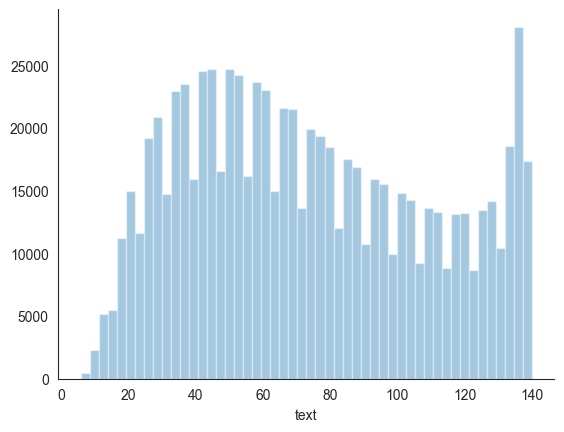

In [56]:
sns.distplot(train.text.str.len(), kde=False)
sns.despine();

In [57]:
train.date.describe()

count                           785417
mean     2009-05-31 06:44:30.727442944
min                2009-04-06 22:19:45
25%                2009-05-28 22:52:34
50%                2009-06-02 02:53:22
75%                2009-06-15 05:08:44
max                2009-06-25 10:28:30
Name: date, dtype: object

In [58]:
train.user.nunique()

415204

In [59]:
train.user.value_counts().head(10)

user
lost_dog           298
webwoke            164
SallytheShizzle    159
mcraddictal        143
tsarnick           133
Karen230683        132
VioletsCRUK        126
what_bugs_u        119
DarkPiano          115
keza34             113
Name: count, dtype: int64

### Create text vectorizer

We create a document-term matrix with 934 tokens as follows:

In [60]:
vectorizer = CountVectorizer(min_df=.001, max_df=.8, stop_words='english')
train_dtm = vectorizer.fit_transform(train.text)

In [61]:
train_dtm

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 3167719 stored elements and shape (785417, 927)>

In [62]:
test_dtm = vectorizer.transform(test.text)

### Train Naive Bayes Classifier

In [63]:
nb = MultinomialNB()
nb.fit(train_dtm, train.polarity)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


### Predict Test Polarity

In [64]:
predicted_polarity = nb.predict(test_dtm)

### Evaluate Results

In [65]:
accuracy_score(test.polarity, predicted_polarity)

0.7768361581920904

### TextBlob for Sentiment Analysis

In [66]:
sample_positive = train.text.loc[21]
print(sample_positive)
parsed_positive = TextBlob(sample_positive)
parsed_positive.polarity

Sad, sad, sad. I don't know why but I hate this feeling  I wanna sleep and I still can't!


-0.625

In [67]:
sample_negative = train.text.loc[1]
print(sample_negative)
parsed_negative = TextBlob(sample_negative)
parsed_negative.polarity

@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds


0.5

In [68]:
def estimate_polarity(text):
    return TextBlob(text).sentiment.polarity

In [69]:
train[['text']].sample(1).assign(sentiment=lambda x: x.text.apply(estimate_polarity)).sort_values('sentiment')

,text,sentiment
150297,wishes that @tatii77 went to ice palace with h...,0.0


### Compare with TextBlob Polarity Score

We also obtain TextBlob sentiment scores for the tweets and note (see left panel in below figure) that positive test tweets receive a significantly higher sentiment estimate. We then use the MultinomialNB ‘s model .predict_proba() method to compute predicted probabilities and compare both models using the respective Area Under the Curve (see right panel below).

In [70]:
test['sentiment'] = test.text.apply(estimate_polarity)

In [71]:
accuracy_score(test.polarity, (test.sentiment>0).astype(int))

0.7429378531073446

#### ROC AUC Scores

In [72]:
roc_auc_score(y_true=test.polarity, y_score=test.sentiment)

0.8254948914431672

In [73]:
print(train['polarity'].value_counts())


polarity
1    393004
0    392413
Name: count, dtype: int64


In [74]:
roc_auc_score(y_true=test.polarity, y_score=nb.predict_proba(test_dtm)[:, 1])

0.8495530012771392

In [75]:
fpr_tb, tpr_tb, _ = roc_curve(y_true=test.polarity, y_score=test.sentiment)
roc_tb = pd.Series(tpr_tb, index=fpr_tb)
fpr_nb, tpr_nb, _ = roc_curve(y_true=test.polarity, y_score=nb.predict_proba(test_dtm)[:, 1])
roc_nb = pd.Series(tpr_nb, index=fpr_nb)

The Naive Bayes model outperforms TextBlob in this case.

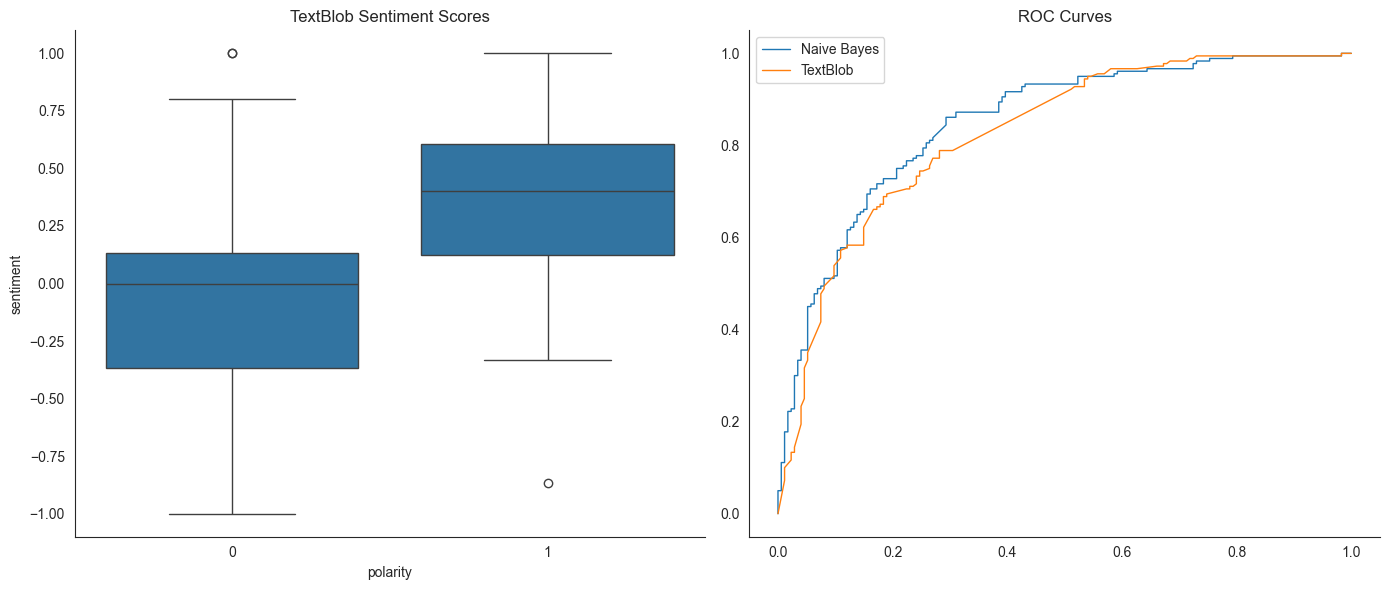

In [76]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))
sns.boxplot(x='polarity', y='sentiment', data=test, ax=axes[0])
axes[0].set_title('TextBlob Sentiment Scores')
roc_nb.plot(ax=axes[1], label='Naive Bayes', legend=True, lw=1, title='ROC Curves')
roc_tb.plot(ax=axes[1], label='TextBlob', legend=True, lw=1)
sns.despine()
fig.tight_layout();

In [77]:
# ===================================================
# 1️⃣ Transformer (DistilBERT) for Sentiment Analysis
# ===================================================
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch

# GPU 사용 여부 확인
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [78]:
# Tokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

In [79]:
# Encode train/test
train_encodings = tokenizer(list(train.text), truncation=True, padding=True, max_length=128)
test_encodings  = tokenizer(list(test.text), truncation=True, padding=True, max_length=128)

In [80]:
# Dataset class
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = TweetDataset(train_encodings, list(train.polarity))
test_dataset  = TweetDataset(test_encodings, list(test.polarity))

In [ ]:
# Model
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2).to(device)

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1, # epoch 수 
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    logging_dir='./logs',
    learning_rate=2e-5,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    save_strategy="no",
    do_eval=True,
    eval_steps=20
)




Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [84]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer
)

# Train
trainer.train()

# Predict
preds = trainer.predict(test_dataset)
pred_labels = preds.predictions.argmax(-1)
pred_probs  = torch.softmax(torch.tensor(preds.predictions), dim=1)[:,1].numpy()  # positive 클래스 확률

Step,Training Loss


KeyboardInterrupt: 

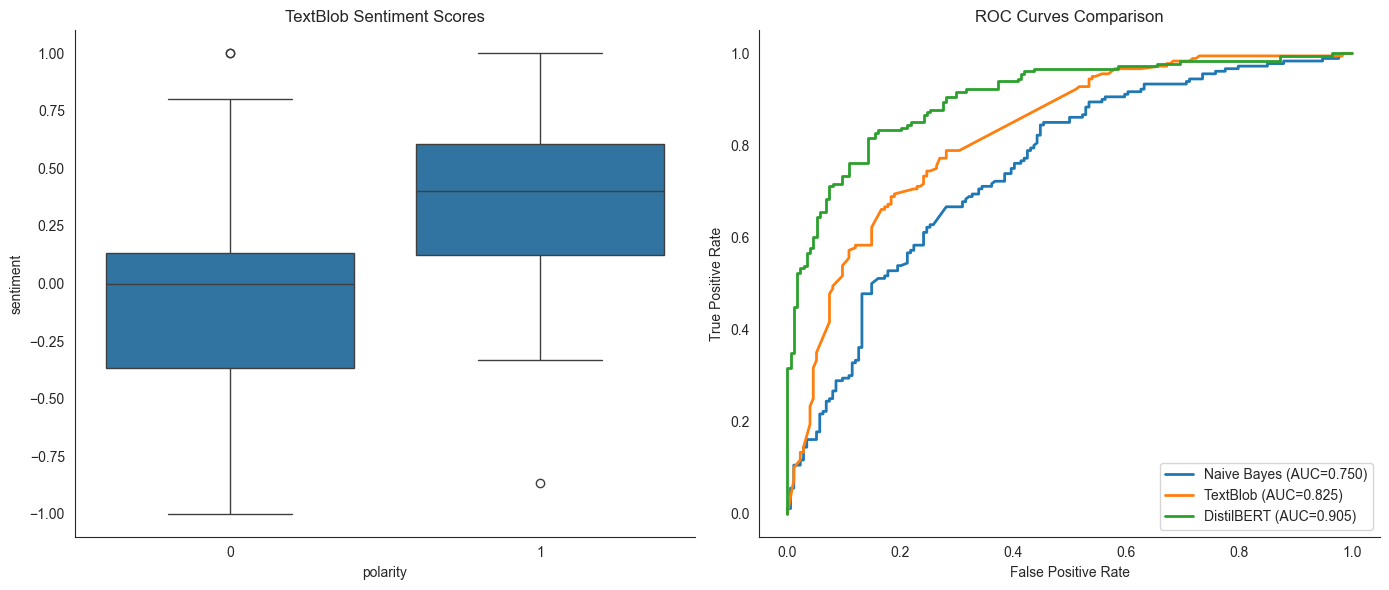

In [ ]:
# =========================================
# 2️⃣ Plot ROC curves for NB, TextBlob, DistilBERT
# =========================================
fpr_distil, tpr_distil, _ = roc_curve(test.polarity, pred_probs)

fig, axes = plt.subplots(ncols=2, figsize=(14,6))

# Left: TextBlob sentiment boxplot
sns.boxplot(x='polarity', y='sentiment', data=test, ax=axes[0])
axes[0].set_title('TextBlob Sentiment Scores')

# Right: ROC curves
roc_nb.plot(ax=axes[1], label=f'Naive Bayes (AUC={roc_auc_score(test.polarity, nb.predict_proba(test_dtm)[:,1]):.3f})', lw=2)
roc_tb.plot(ax=axes[1], label=f'TextBlob (AUC={roc_auc_score(test.polarity, test.sentiment):.3f})', lw=2)
pd.Series(tpr_distil, index=fpr_distil).plot(ax=axes[1], label=f'DistilBERT (AUC={roc_auc_score(test.polarity, pred_probs):.3f})', lw=2)

axes[1].set_title('ROC Curves Comparison')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].legend()
sns.despine()
fig.tight_layout()
